# HST CANDLES images

### CANDLES galaxy catalog
“CANDELS Multi-wavelength Catalogs: Source Identification and Photometry in the CANDELS COSMOS Survey Field”

https://ui.adsabs.harvard.edu/abs/2017ApJS..228....7N

Catalog access: 
https://cdsarc.unistra.fr/viz-bin/cat?J/ApJS/228/7


In [1]:
import gzip

loaddir = 'HSTimages/J_ApJS_228_7/'
with open(loaddir + 'ReadMe', "r") as f:
    lines = f.read()
    lines = lines.strip().split("\n")
    
headers9 = []
for i in range(129,251):
    words = lines[i].strip().split()
    if '-' not in words[0]:
        continue
    headers9.append(words[4])
headers9[-1] = words[3]

headers10 = []
for i in range(269,303):
    words = lines[i].strip().split()
    if '-' not in words[0]:
        continue
    if words[0][-1]=='-':
        headers10.append(words[4])
    else:
        headers10.append(words[3])
    
headers11 = []
for i in range(333,388):
    words = lines[i].strip().split()
    if '-' not in words[0]:
        continue
    if 'Msun' in words[2]:
        headers11.append(words[3])
    else:
        headers11.append(words[4])
        
df9_0 = pd.read_csv(loaddir+'table9.dat.gz',delim_whitespace=True, names=headers9)
df10_0 = pd.read_csv(loaddir+'table10.dat.gz', delim_whitespace=True, names=headers10)
df11_0 = pd.read_csv(loaddir+'table11.dat.gz', delim_whitespace=True, names=headers11)

In [55]:
from utils import *
from astropy.coordinates import SkyCoord

# select sources with z < 0.5 and M*>1e11
sp = np.where((df11_0['zphot']>0) & (df11_0['zphot']<0.5) \
              & (df11_0['Mass']>11) & (df11_0['zphotu68']<0.5))[0]
df9, df10, df11 = df9_0.iloc[sp], df10_0.iloc[sp], df11_0.iloc[sp]

df = df9[['RAdeg','DEdeg']].copy()
df[['zbest','zspec','zphot','zphotl68','zphotu68','Mass']] \
= df11[['zbest','zspec','zphot','zphotl68','zphotu68','Mass']]

df['deg_kpc'] = cosmo.arcsec_per_kpc_proper(df['zbest']).to(u.deg/u.kpc).value
df['SkyCoord'] = SkyCoord(df['RAdeg'], df['DEdeg'], frame='icrs', unit='deg').to_string('hmsdms')

In [56]:
df

,RAdeg,DEdeg,zbest,zspec,zphot,zphotl68,zphotu68,Mass,deg_kpc,SkyCoord
1469,150.142307,2.190654,0.3577,-99.0000,0.358,0.34,0.40,11.1,0.000054,10h00m34.1537s +02d11m26.3544s
2754,150.090706,2.205656,0.4176,-99.0000,0.418,0.39,0.46,11.2,0.000049,10h00m21.7694s +02d12m20.3616s
10561,150.096144,2.298564,0.3890,-99.0000,0.389,0.35,0.41,11.1,0.000051,10h00m23.0746s +02d17m54.8304s
10960,150.095097,2.300495,0.3610,0.3601,0.373,0.35,0.40,11.2,0.000053,10h00m22.8233s +02d18m01.782s
15872,150.113809,2.360722,0.2400,-99.0000,0.240,0.17,0.41,11.1,0.000071,10h00m27.3142s +02d21m38.5992s
17469,150.058065,2.380421,0.3470,0.3460,0.350,0.33,0.38,11.1,0.000055,10h00m13.9356s +02d22m49.5156s
18296,150.080651,2.390262,0.3531,0.3521,0.429,0.34,0.47,11.2,0.000054,10h00m19.3562s +02d23m24.9432s
19215,150.105686,2.399109,0.2540,-99.0000,0.254,0.21,0.42,11.1,0.000068,10h00m25.3646s +02d23m56.7924s


In [74]:
# write the reg file to put circle on FITS images (with DS9)
with open('HSTimages/regions.reg','w') as f:
    for (ra,dec,deg_kpc) in zip(df['RAdeg'],df['DEdeg'],df['deg_kpc']):
        for r in [10,15,20,30,50,90]:
            if r<=30:
                c = 'cyan'
            if r==50:
                c = 'red'
            if r==90:
                c = 'green'
            f.write("j2000; circle {} {} {} # width=2 color={}\n".format(ra,dec,deg_kpc*r,c))

***

MICECAT field 0, 0 < ra < 2, 0 < dec < 2


Text(0.5, 0.98, 'distance to the nearest neighbor in the same halo')

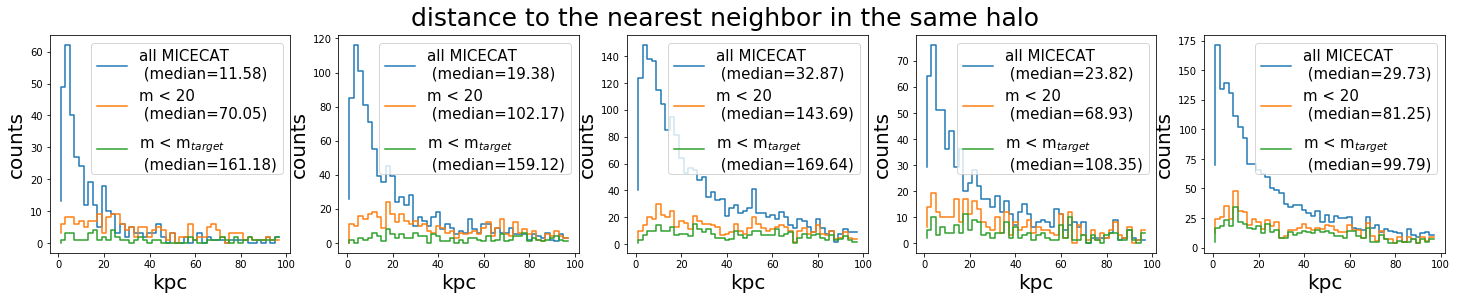

In [1]:
from micecat import *

# df = get_micecat_df(0, add_Rvir=True)

# data = {}
fig, ax = plt.subplots(1, 5, figsize = (25,4))
for ii,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]    
    dfi = df.loc[(df['I']>=m_min) & (df['I']<m_max) \
                   & (df['M_I']>=M_min) & (df['M_I']<M_max) & (df['lmhalo']<14)].copy()
    dfi['kpc_per_pix'] = cosmo.kpc_proper_per_arcmin(dfi['z_cgal']).value*7/60
    galids = np.array(dfi.index)
    haloids = dfi['unique_halo_id'].values
    
#     ds = []
#     dsm = []
#     dsb = []
#     for i in np.random.permutation(len(dfi)):
#         haloid, galid = haloids[i], galids[i]
#         x0, y0, I0, kpp = dfi[['x','y','I','kpc_per_pix']].loc[dfi.index==galid].values[0]
#         df1hi = df[(df['unique_halo_id']==haloid) & (df.index!=galid)].copy()
#         if len(df1hi)==0:
#             continue
#         dxs = np.array(df1hi[['x']] - x0).flatten()
#         dys = np.array(df1hi[['y']] - y0).flatten()
#         ds.append(min(np.sqrt(dxs**2 + dys**2))*kpp)
        
#         df1hi = df1hi[(df1hi['I']<20)].copy()
#         if len(df1hi)==0:
#             continue
#         dxs = np.array(df1hi[['x']] - x0).flatten()
#         dys = np.array(df1hi[['y']] - y0).flatten()
#         dsm.append(min(np.sqrt(dxs**2 + dys**2))*kpp)

#         df1hi = df1hi[(df1hi['I']<I0)].copy()
#         if len(df1hi)==0:
#             continue
#         dxs = np.array(df1hi[['x']] - x0).flatten()
#         dys = np.array(df1hi[['y']] - y0).flatten()
#         dsb.append(min(np.sqrt(dxs**2 + dys**2))*kpp)

#     ds, dsm, dsb = np.array(ds), np.array(dsm), np.array(dsb)
#     data[ii] = {'ds':ds,'dsm':dsm,'dsb':dsb}
    
    dbinedges = np.arange(0,100,2)
    dbins = (dbinedges[1:]+dbinedges[:-1])/2
    h = np.histogram(ds, bins=dbinedges)[0]
    hm = np.histogram(dsm, bins=dbinedges)[0]
    hb = np.histogram(dsb, bins=dbinedges)[0]
    ax[ii].step(dbins,h, label='all MICECAT \n (median=%.2f)'%(np.median(ds)))
    ax[ii].step(dbins,hm, label='m < 20 \n (median=%.2f)'%(np.median(dsm)))
    ax[ii].step(dbins,hb, label='m < m$_{target}$ \n (median=%.2f)'%(np.median(dsb)))
    ax[ii].set_ylabel('counts', fontsize=20)
    ax[ii].set_xlabel('kpc', fontsize=20)
    ax[ii].legend(fontsize=15)
fig.suptitle('distance to the nearest neighbor in the same halo',fontsize=25)

Text(0.5, 0.98, 'distance to the nearest neighbor in the same halo')

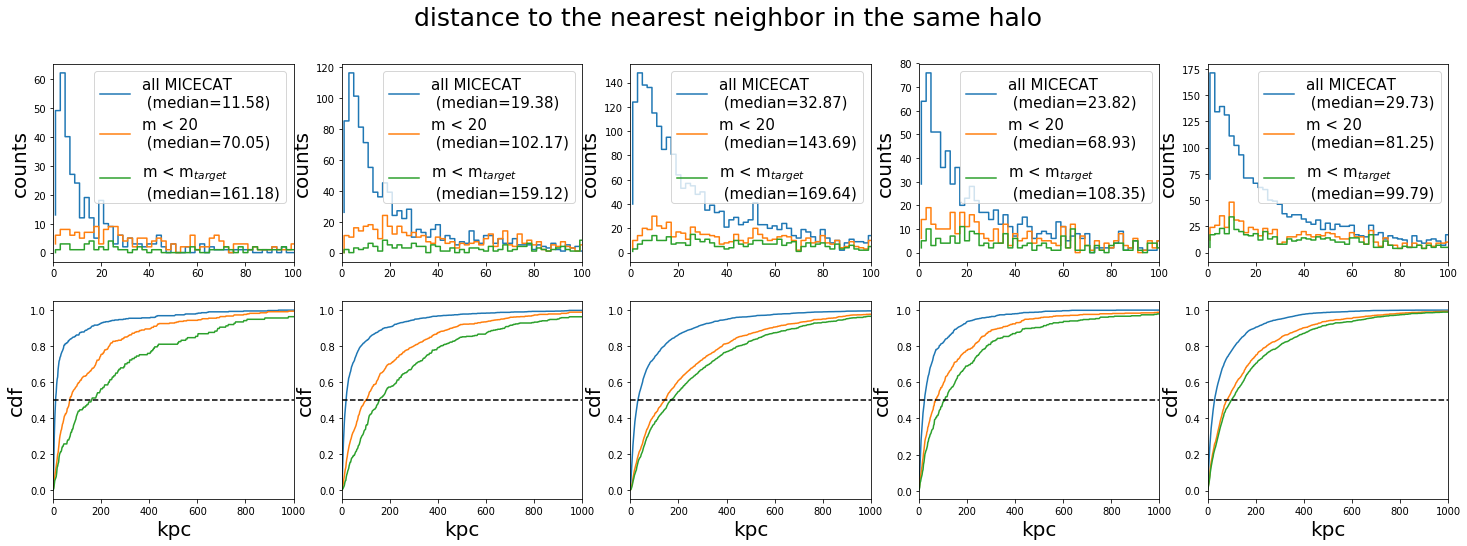

In [23]:
from micecat import *

# df = get_micecat_df(0, add_Rvir=True)

data = {}
fig, ax = plt.subplots(2, 5, figsize = (25,8))
for ii,(im,M_min,M_max) in enumerate(zip([1,2,3,2,3],[-23,-23,-23,-22,-22],[-22,-22,-22,-21,-21])):
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]    
    dfi = df.loc[(df['I']>=m_min) & (df['I']<m_max) \
                   & (df['M_I']>=M_min) & (df['M_I']<M_max) & (df['lmhalo']<14)].copy()
    dfi['kpc_per_pix'] = cosmo.kpc_proper_per_arcmin(dfi['z_cgal']).value*7/60
    galids = np.array(dfi.index)
    haloids = dfi['unique_halo_id'].values
    
    ds = []
    dsm = []
    dsb = []
    for i in np.random.permutation(len(dfi)):
        haloid, galid = haloids[i], galids[i]
        x0, y0, I0, kpp = dfi[['x','y','I','kpc_per_pix']].loc[dfi.index==galid].values[0]
        df1hi = df[(df['unique_halo_id']==haloid) & (df.index!=galid)].copy()
        if len(df1hi)==0:
            continue
        dxs = np.array(df1hi[['x']] - x0).flatten()
        dys = np.array(df1hi[['y']] - y0).flatten()
        ds.append(min(np.sqrt(dxs**2 + dys**2))*kpp)
        
        df1hi = df1hi[(df1hi['I']<20)].copy()
        if len(df1hi)==0:
            continue
        dxs = np.array(df1hi[['x']] - x0).flatten()
        dys = np.array(df1hi[['y']] - y0).flatten()
        dsm.append(min(np.sqrt(dxs**2 + dys**2))*kpp)

        df1hi = df1hi[(df1hi['I']<I0)].copy()
        if len(df1hi)==0:
            continue
        dxs = np.array(df1hi[['x']] - x0).flatten()
        dys = np.array(df1hi[['y']] - y0).flatten()
        dsb.append(min(np.sqrt(dxs**2 + dys**2))*kpp)

    ds, dsm, dsb = np.array(ds), np.array(dsm), np.array(dsb)
    data[ii] = {'ds':ds,'dsm':dsm,'dsb':dsb}
    
    dbinedges = np.arange(0,2000,2)
    dbins = (dbinedges[1:]+dbinedges[:-1])/2
    h = np.histogram(ds, bins=dbinedges)[0]
    hm = np.histogram(dsm, bins=dbinedges)[0]
    hb = np.histogram(dsb, bins=dbinedges)[0]
    ax[0][ii].step(dbins,h, label='all MICECAT \n (median=%.2f)'%(np.median(ds)))
    ax[0][ii].step(dbins,hm, label='m < 20 \n (median=%.2f)'%(np.median(dsm)))
    ax[0][ii].step(dbins,hb, label='m < m$_{target}$ \n (median=%.2f)'%(np.median(dsb)))
    ax[0][ii].set_ylabel('counts', fontsize=20)
    ax[0][ii].legend(fontsize=15)
    ax[0][ii].set_xlim([0,100])
    
    ax[1][ii].plot(dbins, np.cumsum(h)/np.sum(h))
    ax[1][ii].plot(dbins, np.cumsum(hm)/np.sum(hm))
    ax[1][ii].plot(dbins, np.cumsum(hb)/np.sum(hb))
    ax[1][ii].axhline(0.5, c='k', ls='--')
    ax[1][ii].set_xlim([0,1000])
    ax[1][ii].set_ylabel('cdf', fontsize=20)
    ax[1][ii].set_xlabel('kpc', fontsize=20)
fig.suptitle('distance to the nearest neighbor in the same halo',fontsize=25)